<a href="https://colab.research.google.com/github/DKS2301/GRU-MHA-RUL-Forecasting/blob/main/GRU_MHA_model_for_accurate_battery_RUL_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hybrid GRU-MHA model for accurate battery RUL forecasting with feature selection**

## **IMPORTS AND SETUP**

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import scipy.stats as stats

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## **DATA DOWNLOADING AND LOADING**

In [2]:
def load_nasa_battery(filepath):
    """Load NASA battery file with robust error handling."""
    print(f"Loading: {filepath}")
    mat = sio.loadmat(filepath, squeeze_me=True, struct_as_record=False)

    keys = [k for k in mat.keys() if not k.startswith("__")]
    root = mat[keys[0]]

    if hasattr(root, "cycle"):
        cycles = root.cycle
    elif "cycle" in mat:
        cycles = mat["cycle"]
    else:
        raise ValueError("Could not find cycle structure.")

    rows = []
    for idx, c in enumerate(cycles):
        data = getattr(c, "data", None)
        if data is None:
            continue

        V = getattr(data, "Voltage_measured", None)
        I = getattr(data, "Current_measured", None)
        T = getattr(data, "Temperature_measured", None)
        t = getattr(data, "Time", None)
        Cap = getattr(data, "Capacity", None)

        if isinstance(Cap, np.ndarray):
            Cap = float(Cap) if Cap.size == 1 else None

        rows.append({
            "cycle_id": idx,
            "type": getattr(c, "type", None),
            "ambient_temperature": getattr(c, "ambient_temperature", None),
            "capacity": Cap,
            "V": np.array(V) if V is not None else None,
            "I": np.array(I) if I is not None else None,
            "T": np.array(T) if T is not None else None,
            "time": np.array(t) if t is not None else None,
            "length": len(t) if t is not None else 0
        })

    return pd.DataFrame(rows)



def extract_advanced_features(df):
    """Extract comprehensive features with proper scaling considerations."""
    print("\nExtracting advanced features per cycle...")

    # Keep only discharge cycles
    df_dis = df[df["type"] == "discharge"].reset_index(drop=True)

    # Compute SoH
    first_cap = df_dis["capacity"].dropna().iloc[0]
    df_dis["SoH"] = df_dis["capacity"] / first_cap

    # Add temporal features
    df_dis["cycle_number"] = df_dis["cycle_id"]

    def safe_array_op(series, op):
        """Safely apply operation to array column."""
        try:
            arr = np.concatenate([x for x in series.values if x is not None])
            return op(arr.astype(float))
        except:
            return 0.0

    features = []

    for cycle_id, group in df_dis.groupby("cycle_id"):
        # Basic voltage statistics
        V_mean = safe_array_op(group["V"], np.mean)
        V_std = safe_array_op(group["V"], np.std)
        V_max = safe_array_op(group["V"], np.max)
        V_min = safe_array_op(group["V"], np.min)

        # Current statistics
        I_mean = safe_array_op(group["I"], np.mean)
        I_std = safe_array_op(group["I"], np.std)

        # Temperature statistics
        T_mean = safe_array_op(group["T"], np.mean)
        T_std = safe_array_op(group["T"], np.std)

        # Advanced voltage features
        V_arr = np.concatenate([x for x in group["V"].values if x is not None]).astype(float)

        # Energy features
        signal_energy = np.sum(V_arr**2) if len(V_arr) > 0 else 0
        signal_power = signal_energy / len(V_arr) if len(V_arr) > 0 else 0

        # Statistical features
        voltage_range = V_max - V_min
        skewness = stats.skew(V_arr) if len(V_arr) > 2 else 0
        kurtosis = stats.kurtosis(V_arr) if len(V_arr) > 2 else 0

        # Derivative features
        if len(V_arr) > 1:
            voltage_gradient = np.mean(np.abs(np.diff(V_arr)))
        else:
            voltage_gradient = 0

        # Capacity features
        capacity = group["capacity"].dropna().mean()
        soh = group["SoH"].dropna().mean()

        # Critical: Normalized cycle progression
        total_cycles = df_dis["cycle_id"].max()
        cycle_normalized = cycle_id / total_cycles if total_cycles > 0 else 0

        # Rolling window features (last 5 cycles)
        window_size = min(5, len(features) + 1)
        if len(features) >= window_size - 1:
            recent_capacities = [f['capacity'] for f in features[-(window_size-1):]] + [capacity]
            capacity_trend = (recent_capacities[-1] - recent_capacities[0]) / window_size
            capacity_volatility = np.std(recent_capacities)
        else:
            capacity_trend = 0
            capacity_volatility = 0

        # Degradation from start
        capacity_drop = (first_cap - capacity) / first_cap

        features.append({
            "cycle_id": cycle_id,

            # Temporal features (HIGH IMPORTANCE)
            "cycle_normalized": cycle_normalized,
            "cycle_squared": cycle_normalized ** 2,

            # Voltage features
            "voltage_mean": V_mean,
            "voltage_std": V_std,
            "voltage_max": V_max,
            "voltage_min": V_min,
            "voltage_range": voltage_range,
            "voltage_gradient": voltage_gradient,

            # Current features
            "current_mean": I_mean,
            "current_std": I_std,

            # Temperature features
            "temperature_mean": T_mean,
            "temperature_std": T_std,

            # Energy features
            "signal_energy": signal_energy,
            "signal_power": signal_power,

            # Statistical features
            "skewness": skewness,
            "kurtosis": kurtosis,

            # Degradation features (HIGH IMPORTANCE)
            "capacity_drop": capacity_drop,
            "capacity_trend": capacity_trend,
            "capacity_volatility": capacity_volatility,

            # Interaction features
            "cycle_voltage_interaction": cycle_normalized * V_mean,

            # Target
            "capacity": capacity,
            "SoH": soh
        })

    feature_df = pd.DataFrame(features)
    print(f"✓ Extracted {len(feature_df.columns)-2} features from {len(feature_df)} cycles")
    return feature_df

## **DATA PREPROCESSING AND FEATURE ENGINEERING**

In [3]:

def preprocess_data_robust(df, target_column='SoH'):
    """Improved preprocessing with RobustScaler and proper feature handling."""

    # Separate features and target
    feature_cols = [col for col in df.columns if col not in ['SoH', 'capacity', 'cycle_id']]
    X = df[feature_cols].copy()
    y = df[target_column].copy()

    print(f"\nFeature shape before cleaning: {X.shape}")

    # Remove zero-variance features
    var = X.var()
    non_zero_var_cols = var[var > 1e-10].index.tolist()
    X = X[non_zero_var_cols]

    print(f"Feature shape after variance check: {X.shape}")

    # Use RobustScaler (less sensitive to outliers than MinMaxScaler)
    scaler_X = RobustScaler()
    scaler_y = StandardScaler()  # Keep target in reasonable range

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

    # Check for any NaN or Inf
    X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=1.0, neginf=-1.0)

    print(f"\nScaled features - Mean: {X_scaled.mean():.4f}, Std: {X_scaled.std():.4f}")
    print(f"Scaled target - Mean: {y_scaled.mean():.4f}, Std: {y_scaled.std():.4f}")
    print(f"Scaled target range: [{y_scaled.min():.4f}, {y_scaled.max():.4f}]")

    return X_scaled, y_scaled, scaler_X, scaler_y, X.columns.tolist()


## **MODEL ARCHITECTURE**

In [10]:

def build_improved_gru_mha_v2(n_features, n_timesteps=1):
    """
    FIXED GRU-MHA architecture with:
    - Simpler structure to prevent overfitting
    - Better gradient flow
    - Layer normalization instead of batch norm
    - Reduced dropout
    - Skip connections
    """

    input_layer = layers.Input(shape=(n_timesteps, n_features), name='input')

    # First GRU layer (unidirectional for simplicity)
    x = layers.GRU(64, return_sequences=True,
                   kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = layers.LayerNormalization()(x)  # Better than BatchNorm for small batches
    x = layers.Dropout(0.2)(x)  # Reduced dropout

    # Second GRU layer
    x = layers.GRU(32, return_sequences=True,
                   kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.LayerNormalization()(x)

    # Multi-head attention
    attn = layers.MultiHeadAttention(
        num_heads=4,  # Reduced heads
        key_dim=16,
        dropout=0.1
    )(x, x)

    # Residual connection
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    # Global pooling (better than Flatten for sequences)
    x_mean = layers.GlobalAveragePooling1D()(x)
    x_max = layers.GlobalMaxPooling1D()(x)
    x = layers.Concatenate()([x_mean, x_max])

    # Dense layers with skip connection
    x = layers.Dense(64, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.2)(x)

    x_skip = x  # Store for skip connection

    x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_skip)
    x = layers.Dropout(0.1)(x)
    x = layers.Add()([x, x_skip])  # Now shapes match


    x = layers.Dense(16, activation='relu')(x)

    # Output layer - LINEAR activation (critical!)
    output = layers.Dense(1, activation='linear', name='output')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model


def custom_soh_loss(y_true, y_pred):
    """
    Custom loss that combines MSE with MAE for better gradient flow.
    MSE for large errors, MAE for small errors.
    """
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    # Weighted combination
    return 0.7 * mse + 0.3 * mae

## **TRAINING FUNCTIONS**

In [5]:

def train_model_improved_v2(X_train, y_train, X_val, y_val,
                            epochs=300, batch_size=16):
    """
    Improved training with:
    - Better learning rate schedule
    - Custom loss function
    - Gradient clipping
    - Model checkpointing
    """

    n_features = X_train.shape[1]

    # Reshape for time-series (add timestep dimension)
    X_train_3d = X_train.reshape(-1, 1, n_features)
    X_val_3d = X_val.reshape(-1, 1, n_features)

    # Build model
    model = build_improved_gru_mha_v2(n_features)

    # Use custom optimizer with gradient clipping
    optimizer = Adam(
        learning_rate=0.001,
        clipnorm=1.0  # Gradient clipping prevents exploding gradients
    )

    model.compile(
        optimizer=optimizer,
        loss=custom_soh_loss,  # Custom loss
        metrics=['mae', 'mse']
    )

    print("\n" + "="*70)
    print("MODEL ARCHITECTURE")
    print("="*70)
    model.summary()
    print(f"\nTotal parameters: {model.count_params():,}")

    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=40,
        restore_best_weights=True,
        verbose=1,
        min_delta=1e-5
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=15,
        min_lr=1e-6,
        verbose=1
    )

    # Save best model
    checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )

    print("\n" + "="*70)
    print("TRAINING MODEL")
    print("="*70)
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Batch size: {batch_size}")
    print(f"Max epochs: {epochs}")
    print("="*70 + "\n")

    history = model.fit(
        X_train_3d, y_train,
        validation_data=(X_val_3d, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr, checkpoint],
        verbose=1
    )

    return model, history


# **EVALUATION AND VISUALIZATION**

In [6]:

def evaluate_predictions(y_true, y_pred, scaler_y, phase="Test"):
    """Comprehensive evaluation with proper inverse transform."""

    # Inverse transform
    y_true_orig = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    # Clip predictions to valid SoH range [0, 1]
    y_pred_orig = np.clip(y_pred_orig, 0, 1)

    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    mse = mean_squared_error(y_true_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_orig, y_pred_orig)
    mape = np.mean(np.abs((y_true_orig - y_pred_orig) / (y_true_orig + 1e-8))) * 100

    print(f"\n{'='*70}")
    print(f"{phase.upper()} SET PERFORMANCE")
    print(f"{'='*70}")
    print(f"MAE:        {mae:.6f}")
    print(f"RMSE:       {rmse:.6f}")
    print(f"R² Score:   {r2:.4f} ({r2*100:.2f}%)")
    print(f"MAPE:       {mape:.2f}%")
    print(f"Mean Error: {np.mean(y_true_orig - y_pred_orig):.6f}")
    print(f"Std Error:  {np.std(y_true_orig - y_pred_orig):.6f}")
    print(f"{'='*70}\n")

    return {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'y_true': y_true_orig,
        'y_pred': y_pred_orig
    }


def plot_results(history, test_metrics):
    """Comprehensive result visualization."""

    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    # Training history - Loss
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=11)
    ax1.set_ylabel('Loss', fontsize=11)
    ax1.set_title('Training History - Loss', fontweight='bold', fontsize=12)
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Training history - MAE
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(history.history['mae'], label='Train MAE', linewidth=2)
    ax2.plot(history.history['val_mae'], label='Val MAE', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=11)
    ax2.set_ylabel('MAE', fontsize=11)
    ax2.set_title('Training History - MAE', fontweight='bold', fontsize=12)
    ax2.legend()
    ax2.grid(alpha=0.3)

    y_true = test_metrics['y_true']
    y_pred = test_metrics['y_pred']

    # Predictions plot
    ax3 = fig.add_subplot(gs[1, :])
    indices = np.arange(len(y_true))
    ax3.plot(indices, y_true, 'o-', label='Actual SoH', linewidth=2, markersize=6, color='blue')
    ax3.plot(indices, y_pred, 's-', label='Predicted SoH', linewidth=2, markersize=6,
             alpha=0.7, color='orange')
    ax3.fill_between(indices, y_true, y_pred, alpha=0.2, color='red')
    ax3.set_xlabel('Sample Index', fontsize=11)
    ax3.set_ylabel('State of Health (SoH)', fontsize=11)
    ax3.set_title('Actual vs Predicted SoH', fontweight='bold', fontsize=13)
    ax3.legend(fontsize=10)
    ax3.grid(alpha=0.3)

    # Scatter plot
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.scatter(y_true, y_pred, alpha=0.6, s=80)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit')
    ax4.set_xlabel('Actual SoH', fontsize=11)
    ax4.set_ylabel('Predicted SoH', fontsize=11)
    ax4.set_title('Prediction Scatter Plot', fontweight='bold', fontsize=12)
    ax4.legend()
    ax4.grid(alpha=0.3)

    # Error distribution
    ax5 = fig.add_subplot(gs[2, 1])
    errors = y_true - y_pred
    ax5.hist(errors, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
    ax5.axvline(0, color='r', linestyle='--', linewidth=2)
    ax5.axvline(errors.mean(), color='g', linestyle='--', linewidth=2,
                label=f'Mean: {errors.mean():.4f}')
    ax5.set_xlabel('Prediction Error', fontsize=11)
    ax5.set_ylabel('Frequency', fontsize=11)
    ax5.set_title('Error Distribution', fontweight='bold', fontsize=12)
    ax5.legend()
    ax5.grid(alpha=0.3)

    plt.suptitle('Improved GRU-MHA Model Performance', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()



## **COMPLETE PIPELINE EXECUTION**

In [7]:

def run_complete_pipeline(file_path, battery_name='B0005', train_split=0.7):
    """Complete improved pipeline."""

    print("\n" + "="*70)
    print(f"PROCESSING: NASA Battery {battery_name}")
    print("="*70)

    # Load and extract features
    df_raw = load_nasa_battery(file_path)
    df = extract_advanced_features(df_raw)

    print(f"\n✓ Loaded {len(df)} discharge cycles")
    print(f"✓ Feature DataFrame shape: {df.shape}")

    # Visualize SoH degradation
    plt.figure(figsize=(10, 5))
    plt.plot(df['cycle_id'], df['SoH'], 'o-', linewidth=2, markersize=5)
    plt.xlabel('Cycle Number', fontsize=11)
    plt.ylabel('State of Health (SoH)', fontsize=11)
    plt.title(f'Battery Degradation - {battery_name}', fontweight='bold', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nSoH statistics:")
    print(f"  Range: [{df['SoH'].min():.4f}, {df['SoH'].max():.4f}]")
    print(f"  Mean: {df['SoH'].mean():.4f}")
    print(f"  Std: {df['SoH'].std():.4f}")
    print(f"  Total degradation: {(1 - df['SoH'].min()) * 100:.2f}%")

    # Preprocess
    X_scaled, y_scaled, scaler_X, scaler_y, feature_names = preprocess_data_robust(df)

    print(f"\n✓ Using {len(feature_names)} input features")
    print(f"✓ Top features: {feature_names[:5]}")

    # Train-test split
    split_idx = int(train_split * len(X_scaled))

    X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
    y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

    print(f"\n✓ Training samples: {len(y_train)}")
    print(f"✓ Test samples: {len(y_test)}")

    # Train model
    model, history = train_model_improved_v2(
        X_train, y_train,
        X_test, y_test
    )

    # Predictions
    print("\n" + "="*70)
    print("EVALUATING MODEL")
    print("="*70)

    X_train_3d = X_train.reshape(-1, 1, X_train.shape[1])
    X_test_3d = X_test.reshape(-1, 1, X_test.shape[1])

    y_pred_train = model.predict(X_train_3d, verbose=0).flatten()
    y_pred_test = model.predict(X_test_3d, verbose=0).flatten()

    # Evaluate
    train_metrics = evaluate_predictions(y_train, y_pred_train, scaler_y, "Training")
    test_metrics = evaluate_predictions(y_test, y_pred_test, scaler_y, "Test")

    # Check for constant predictions
    pred_variance = np.var(test_metrics['y_pred'])
    print(f"\n{'='*70}")
    print("PREDICTION ANALYSIS")
    print(f"{'='*70}")
    print(f"Prediction variance: {pred_variance:.6f}")
    print(f"Prediction range: [{test_metrics['y_pred'].min():.4f}, {test_metrics['y_pred'].max():.4f}]")
    print(f"Prediction std: {np.std(test_metrics['y_pred']):.6f}")

    if pred_variance < 1e-4:
        print("\n⚠️  WARNING: Model predictions have very low variance!")
        print("This suggests the model may be stuck. Check:")
        print("  - Feature scaling")
        print("  - Learning rate")
        print("  - Model architecture")
    else:
        print("\n✓ Model predictions show good variance")
    print(f"{'='*70}\n")

    # Visualize
    plot_results(history, test_metrics)

    print("\n" + "="*70)
    print("✓ PIPELINE COMPLETED SUCCESSFULLY")
    print("="*70)

    return {
        'model': model,
        'history': history,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'feature_names': feature_names
    }



PROCESSING: NASA Battery B0005
Loading: /data/nasa/B0005.mat

Extracting advanced features per cycle...
✓ Extracted 21 features from 168 cycles

✓ Loaded 168 discharge cycles
✓ Feature DataFrame shape: (168, 23)


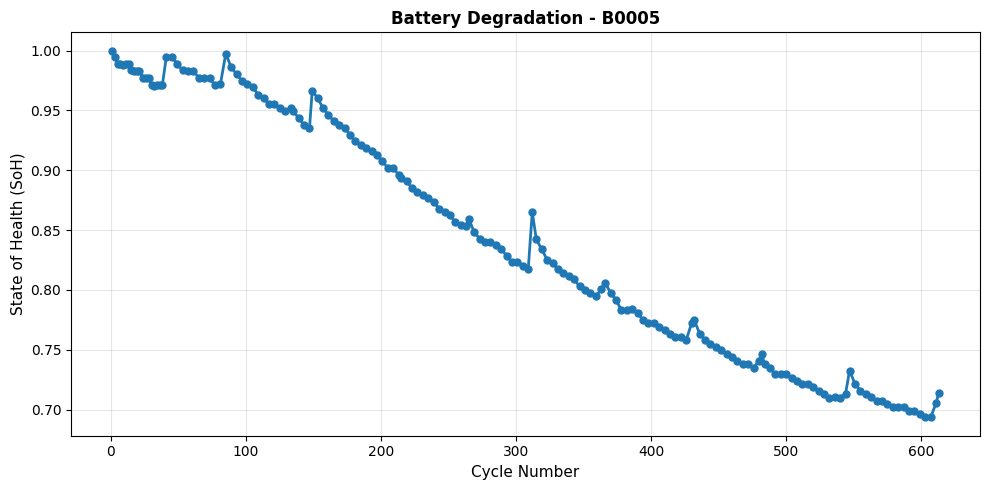


SoH statistics:
  Range: [0.6935, 1.0000]
  Mean: 0.8470
  Std: 0.1026
  Total degradation: 30.65%

Feature shape before cleaning: (168, 20)
Feature shape after variance check: (168, 20)

Scaled features - Mean: 0.0105, Std: 0.9483
Scaled target - Mean: -0.0000, Std: 1.0000
Scaled target range: [-1.5015, 1.4959]

✓ Using 20 input features
✓ Top features: ['cycle_normalized', 'cycle_squared', 'voltage_mean', 'voltage_std', 'voltage_max']

✓ Training samples: 117
✓ Test samples: 51

MODEL ARCHITECTURE


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 1, 20)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 1, 64)     │     16,512 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ gru_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1, 64)     │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 1, 32)     │      9,408 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 32)     │         64 │ gru_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 32)     │      8,416 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1, 32)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 32)     │         64 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ layer_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      4,160 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 64)        │          0 │ dropout_7[0][0],  │
│                     │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │      1,040 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         17 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 43,969 (171.75 KB)

 Trainable params: 43,969 (171.75 KB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 43,969

TRAINING MODEL
Training samples: 117
Validation samples: 51
Batch size: 16
Max epochs: 300

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 2.4211 - mae: 1.3399 - mse: 2.5439 - val_loss: 0.7351 - val_mae: 0.5868 - val_mse: 0.4629 - learning_rate: 0.0010
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.5636 - mae: 0.4320 - mse: 0.2857 - val_loss: 0.4733 - val_mae: 0.3190 - val_mse: 0.2102 - learning_rate: 0.0010
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4725 - mae: 0.3605 - mse: 0.1928 - val_loss: 0.6286 - val_mae: 0.4908 - val_mse: 0.3650 - learning_rate: 0.0010
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4312 - mae: 0.3217 - mse: 0.1569 - val_loss: 0.7990 - val_mae: 0.6726 - val_mse: 0.5369 - learning_rate: 0.0010
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4185 - mae: 0.3051 - mse: 0.1523 - val_loss: 0.7095 - val_mae: 0.6209 - val_mse: 0.4371 - learning_rate: 0.0010
Epoch 6/300
8/8 ━━━

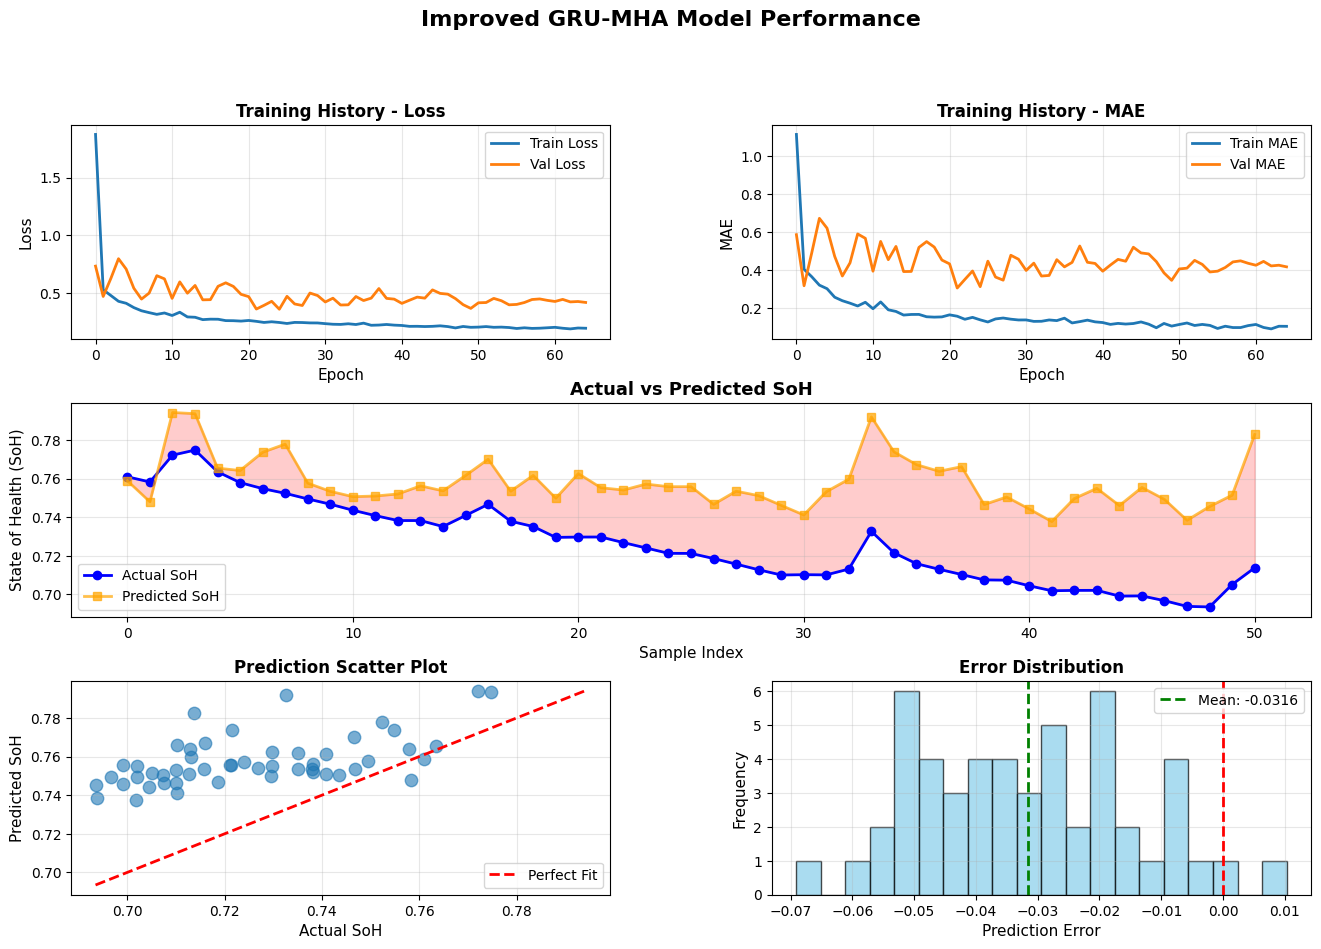


✓ PIPELINE COMPLETED SUCCESSFULLY

✓ Results stored in 'results' dictionary
✓ Access metrics: results['test_metrics']

Key improvements implemented:
  1. RobustScaler instead of MinMaxScaler
  2. Custom loss function (MSE + MAE)
  3. Gradient clipping
  4. Layer normalization
  5. Reduced dropout
  6. Skip connections
  7. Global pooling
  8. L2 regularization


In [11]:

if __name__ == "__main__":
    # Run pipeline
    results = run_complete_pipeline('/data/nasa/B0005.mat', 'B0005')

    print("\n✓ Results stored in 'results' dictionary")
    print("✓ Access metrics: results['test_metrics']")
    print("\nKey improvements implemented:")
    print("  1. RobustScaler instead of MinMaxScaler")
    print("  2. Custom loss function (MSE + MAE)")
    print("  3. Gradient clipping")
    print("  4. Layer normalization")
    print("  5. Reduced dropout")
    print("  6. Skip connections")
    print("  7. Global pooling")
    print("  8. L2 regularization")